Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menu bar, select Cell$\rightarrow$Run All).

Make sure that in addition to the code, you provide written answers for all questions of the assignment. 

Below, please fill in your name and collaborators:

In [220]:
NAME = "Yu-Tzu Wu"
COLLABORATORS = ""

## Assignment 2 - Data Analysis using Pandas
**(15 points total)**

For this assignment, we will analyze the open dataset with data on the passengers aboard the Titanic.

The data file for this assignment can be downloaded from Kaggle website: https://www.kaggle.com/c/titanic/data, file `train.csv`. It is also attached to the assignment page. The definition of all variables can be found on the same Kaggle page, in the Data Dictionary section.

Read the data from the file into pandas DataFrame. Analyze, clean and transform the data to answer the following question: 

**What categories of passengers were most likely to survive the Titanic disaster?**

**Question1. (Conclusion from the analysis below):** _(4 points)_
1. The answer to the main question - What categories of passengers were most likely to survive the Titanic disaster? _(2 points)_
2. The detailed explanation of the logic of the analysis. _(2 points)_
* From the perspective of physical attributes individually, if a passenger is a "female" (Part 4), she has a better survival rate compared to a male passenger. If a passenger is in his/her infancy and childhood (0-12 yr), he/she has a higher survival rate compared to other passengers in different age categories. However, if considering the combined two factors, the highest survival rate can be observed in the group of "Female (19-40yr)" passengers due to the significant interaction of Sex x Age_Category (Refer to Part 5).
* From the perspective of socioeconomic attributes individually, passengers from "Pclass 3" have significantly higher survival rates than the other classes. The identical result can be observed in the "Fare_Category". The more they paid for their ticket, the higher the survival rate shown since the Pclass has a high correlation with the ticket fare. Then, passengers who had family revealed a higher survival rate than those who were alone on the Titanic. Generally, a passenger who was most likely to survive would be "Living in Pclass 3 and having Family".

* According to the result from Part 7, "Sex", "Age_Category", "Pclass", and "Embarked" revealed significant main effects, and "Sex x Pclass", "Age_Category x Pclass" and "Age_Category x Sex" revealed significant 2-factor interaction. While every attribute combined, the category of the passenger who is "Female (19-40yr and having family) from the Pclass 3 and mounted from Cherbourg" is most likely to survive in the crush. 

**Question 2.** _(3 points)_

1. What other attributes did you use for the analysis? Explain how you used them and why you decided to use them. 
* From original attributes, I include "Sex", "Pclass" and "Embarked". The other attributes, "Age_Category", "Fare_Category" and "Family_Category", I transformed them into categorical variables to ensure to fit the model. For each main factor, chi-square revealed a significant effect except "Age_Category." 

2. Provide a complete list of all attributes used. 
* Please check the python cell in Part 2 below.

**Question 3.**  _(3 points)_

1. Did you engineer any attributes (created new attributes)? If yes, explain the rationale and how the new attributes were used in the analysis.

* Besides the initial attributes from the data, I created "Family_Category" which summarizes both "SipSb" and "Parch". 
* I transformed the continuous variables "Age" and "Family_Category" into categorical age ranges. As shown in Part 3, the Age vs Survived and Family_Catgory vs Survived don't fit very well within the logistic regression model, so I decided to use them as categorical variables. Although "Age_Category" in the chi-square function revealed that the p-value is not significant (p=0.147); however, a significant interaction was observed within Age_Category x Sex in the ANOVA model.
* Also, I transformed the continuous variable "Fare" into categorical. As shown in the chi-square result in Part 4, there is a main significant effect (p<0.00001)

2. If you have excluded any attributes from the analysis, provide an explanation of why you believe they can be excluded.
* Yes, I excluded the "Passenger_id" since it's just the sequence,  as well as "Name", and "Ticket" which are name variables. I also excluded "Cabinet" as too many missing values.  

**Question 4.**  _(5 points)_
* How did you treat missing values for those attributes that you included in the analysis (for example, `age` attribute)? Provide a detailed explanation in the comments.

1) Please refer to Part 1, initally, I summarized the missing values of each attribute, and there are only two variables ("Age" and "Embarked") showing missing values. There are a total of 177 missing values in "Age", and what I did is compute the mean and SD of the existing values and generate randomized values based on the mean age value in regards to the SD, and insert the values in the nan of Age. 
2) Since there are only 2 missing values in "Embarked", I generated 2 randomized values for data imputation.

**Import Python libraries** 

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.stats.multicomp as mc

**1. Read Titanic dataset (columns, information)**

In [222]:
Titanic_data=pd.read_csv('train.csv')
Titanic_data
print(Titanic_data.nunique())

PassengerId    890
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


**2. Dataset preparation**
- Attribute organization
- Data categorization (adding columns: Age_Category, Fare_Category, Family_Category)
- Data imputation (Age and Embarked)
- Dropping useless columns (e.g., Passenger_id, Name, Ticket, Cabinet)

In [223]:
# 1. Sex
Titanic_data["Sex"].isnull().sum() # no missing data

# 2. Age
is_null = Titanic_data["Age"].isnull().sum() # missing data
print(is_null)
mean = Titanic_data["Age"].mean()
std = Titanic_data["Age"].std()
rand_age = np.random.randint(mean - std, mean + std, size = is_null) # compute random numbers between the mean, std and is_null
age_slice = Titanic_data["Age"].copy() # fill NaN values in Age column with random values generated
age_slice[np.isnan(age_slice)] = rand_age
Titanic_data["Age"] = age_slice
Titanic_data["Age"] = Titanic_data["Age"].astype(int)

Titanic_data['Age_Category'] = pd.cut(Titanic_data['Age'], bins=[0,3,12,18,40,65,100], labels=['0-3','4-12','13-18','19-40','41-65','Above 65'])

# 3. Pclass
Titanic_data["Pclass"].isnull().sum() # no missing data

# 4. Fare
Titanic_data["Fare"].isnull().sum() # no missing data
Titanic_data['Fare_Category'] = pd.cut(Titanic_data['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid','High_Mid','High'])

# 5 Alone or having family
Titanic_data["Family_NB"]=Titanic_data.SibSp+Titanic_data.Parch
Titanic_data["Family_NB"].isnull().sum() # no missing data
Titanic_data['Family_Category'] = pd.cut(Titanic_data['Family_NB'], bins=[-1,0,10], labels=['Alone','Having Family'])

# 6. Embarked
Titanic_data["Embarked"].isnull().sum() # 2 missing data
Titanic_data.Embarked.fillna(Titanic_data.Embarked.mode()[0], inplace = True)

#Drop the columns we dont need
Titanic_data.drop(['PassengerId', 'Name','Ticket','Cabin'], axis=1, inplace=True)
Titanic_data
print(Titanic_data.columns)

177
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Age_Category', 'Fare_Category', 'Family_NB',
       'Family_Category'],
      dtype='object')


**3. Logistic regression test**

- Nonparametric test for continuous predictive variable (Age, Family_NB and Fare) vs categorical outcome variable (Survived).

- "Age" and "Family_NB" don't fit well with the model.

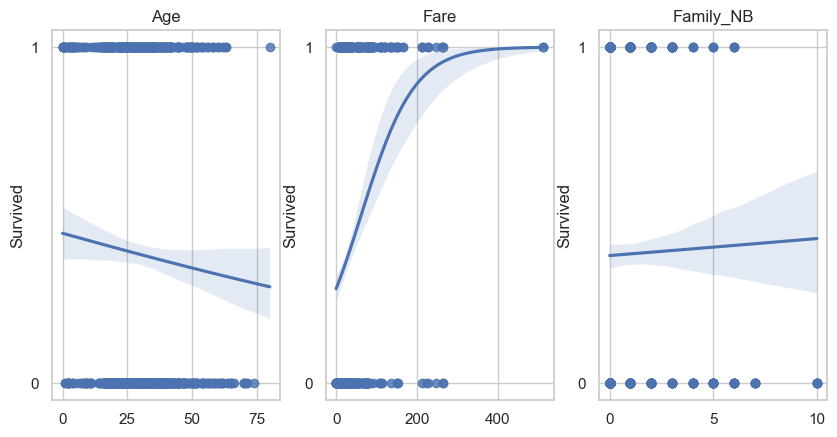

In [224]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns

def Survived_Rate_LR(feature):
    attribute=np.array(Titanic_data[feature]).reshape(-1,1)
    Survived=np.array(Titanic_data.Survived)
    model = LogisticRegression().fit(attribute,Survived)
    fig=sns.regplot(x=Titanic_data[feature],  y=Titanic_data["Survived"], data=Titanic_data, logistic=True)
    fig.set_title(feature)
    fig.set_xlabel('')
    fig.set_yticks([0,1])

fig1, axs = plt.subplots(ncols=3)
fig1.set_figwidth(10)
plt.subplot(1,3,1)                   
Survived_Rate_LR('Age')  
plt.subplot(1,3,2)                   
Survived_Rate_LR('Fare')  
plt.subplot(1,3,3)                   
Survived_Rate_LR('Family_NB')  

**4. Chi-square test**
- Nonparametric test for the categorical predictive variable (all the 6 attributes) vs categorical outcome variable (Survived).

- All the attributes revealed significant effects in the Chi-square test except "Age" (p=0.147).

- The result of the Chi-square test was printed in the order of (X^2, p, df).

- Post-hoc multiple comparison (Bonferroni) can be applied (uncomment the code below) if needed.

(263.05057407065567, 7.573447336653259e-58, 2)
(9.415408165513647, 0.1515281942213628, 6)
(102.88898875696057, 3.7172827565789965e-22, 3)
(61.47635466472883, 1.419584285515385e-12, 4)
(36.85013084754587, 9.956249188538329e-09, 2)
(25.964452881874788, 9.702257009382888e-06, 3)


/var/folders/nr/ck3cwn7s2jj5zk8z_1gk0hxh0000gn/T/ipykernel_1403/2076133963.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  featuredata=Titanic_data.groupby(feature)['Survived']
/var/folders/nr/ck3cwn7s2jj5zk8z_1gk0hxh0000gn/T/ipykernel_1403/2076133963.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  featuredata=Titanic_data.groupby(feature)['Survived']
/var/folders/nr/ck3cwn7s2jj5zk8z_1gk0hxh0000gn/T/ipykernel_1403/2076133963.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

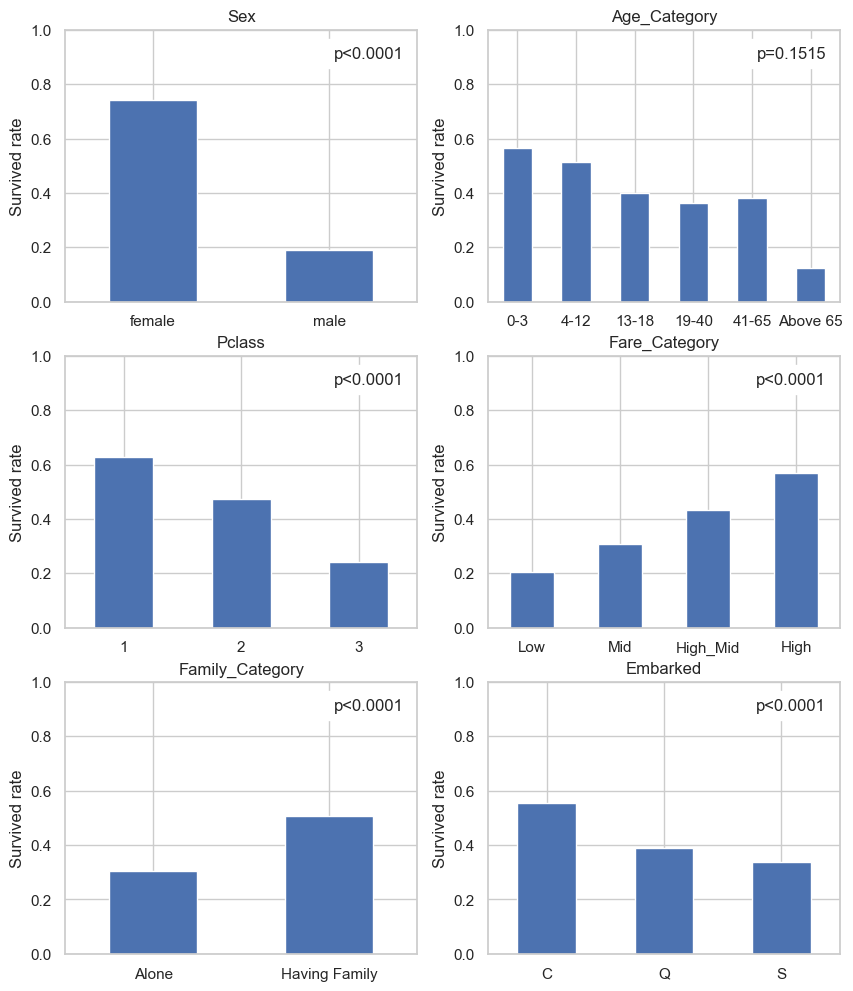

In [225]:
from scipy.stats import chi2_contingency 
#from sklearn.preprocessing import LabelEncoder

def Survived_Rate_ch(feature):
    featuredata=Titanic_data.groupby(feature)['Survived']
    featureSR=featuredata.mean()
    featureSR.sort_index(axis=0).plot(kind="bar",figsize=(10,12), title=feature, xlabel='', ylabel='Survived rate', ylim=(0,1), rot=0)    
    
    #post-hoc test for mutiple comparison (Bonferroni)
    #Titanic_data[feature] = LabelEncoder().fit_transform(Titanic_data[feature])
    #comp = mc.MultiComparison(Titanic_data['Survived'], Titanic_data[feature])
    #tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf") 
    
    chisqt = pd.crosstab(Titanic_data.Survived, Titanic_data[feature], margins=True)
    value = np.array([chisqt.iloc[0][0:chisqt.shape[1]].values,chisqt.iloc[1][0:chisqt.shape[1]].values])
    p=chi2_contingency(value)[1]
    print(chi2_contingency(value)[0:3])
    if p< 0.0001:
        plt.text(.96,.94,"p<0.0001" , bbox={'facecolor':'w','pad':5}, ha="right", va="top", transform=plt.gca().transAxes )
    else:
        p=round(p,4)
        plt.text(.96,.94,"p={}".format(p) , bbox={'facecolor':'w','pad':5}, ha="right", va="top", transform=plt.gca().transAxes )

plt.subplot(3,2,1)                   
Survived_Rate_ch('Sex')
plt.subplot(3,2,2)                   
Survived_Rate_ch('Age_Category')                 
plt.subplot(3,2,3) 
Survived_Rate_ch('Pclass')
plt.subplot(3,2,4)
Survived_Rate_ch('Fare_Category')
plt.subplot(3,2,5)
Survived_Rate_ch('Family_Category')
plt.subplot(3,2,6)
Survived_Rate_ch('Embarked')

**5. Physical attributes (e.g.,...Age + Sex)**

Unfortunately, from the result of the logistic regression model (Part 3) shown above, Age doesn't fit pretty well with the LR model. Therefore, the transformed categorical "Age_Category" was examined in the two-way ANOVA. "Age" and "Sex" are categorized into physical attributes and I suspected that there is an interaction between the two variables. 
- Two-way ANOVA was applied to test. The table below shows that there is a significant effect in the main factor of "Sex" (p<0.0001) but not "Age_Category" (p=0.568). 
- Significant intercation (p<0.0001) was observed within Sex x Age. 
- The bar graph revealed that female vs male has significantly higher survival rate, and the significance was enlarged according to the increase in age. 

/var/folders/nr/ck3cwn7s2jj5zk8z_1gk0hxh0000gn/T/ipykernel_1403/4160153945.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Physic2=Titanic_data.groupby(['Age_Category','Sex' ])['Survived'].mean()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Sex),62.385964,1.0,389.442002,5.747953e-72
C(Age_Category),0.581309,5.0,0.725760,5.744354e-01
C(Sex):C(Age_Category),4.748345,5.0,5.928272,2.119192e-05
Residual,139.848671,873.0,NaN,NaN


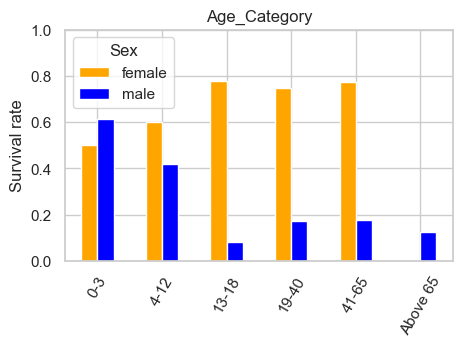

In [226]:
Physic2=Titanic_data.groupby(['Age_Category','Sex' ])['Survived'].mean()
Physic2.unstack().plot.bar(title='Age_Category', xlabel='',ylabel='Survival rate', figsize=(5,3),ylim=(0,1), legend=True, color=['Orange', 'Blue'],rot=60)

import statsmodels as sm
from statsmodels.formula.api import ols

model = ols('Survived ~ C(Sex) + C(Age_Category) + C(Sex):C(Age_Category)', data=Titanic_data).fit()
sm.api.stats.anova_lm(model, typ=2) 


**6. Socioeconomic attributes (e.g.,..."Pclass", "Fare_Category", and "Family_Category")**

- Boxplot and violinplot below showed the distribution of Pclass vs Fare (continuous) and Pclass vs Family_NB (Continous) respectively. It can be confirmed that Pclass and Fare have a high correlation, which suggests that the higher the Pclass is, the higher the Fare is. Visually, we don't see any trend within Pclass vs Family_NB. Therefore, we will use ANOVA to test their interaction.

- From ANOVA, a significant main effect can be observed in "Pclass" (p<0.0001) and "Family_Category" (p<0.001) but not in "Fare_Category" (0.996). 

- Significant interaction can be observed within Family_Category vs Fare_Category (p<0.05). (I don't recognize the interaction of Pclass and Family_Category as significant because of the p=0.047...).


/var/folders/nr/ck3cwn7s2jj5zk8z_1gk0hxh0000gn/T/ipykernel_1403/2506316606.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Socioeco1=Titanic_data.groupby(['Pclass', 'Fare_Category'])['Survived'].mean()
/var/folders/nr/ck3cwn7s2jj5zk8z_1gk0hxh0000gn/T/ipykernel_1403/2506316606.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Socioeco2=Titanic_data.groupby(['Pclass', 'Family_Category'])['Survived'].mean()
/var/folders/nr/ck3cwn7s2jj5zk8z_1gk0hxh0000gn/T/ipykernel_1403/2506316606.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

,sum_sq,df,F,PR(>F)
C(Pclass),8.754477,2.0,21.672812,6.720334e-10
C(Fare_Category),0.012001,3.0,0.019806,9.962125e-01
C(Family_Category),2.599444,1.0,12.870502,3.535386e-04
C(Pclass):C(Fare_Category),1.333223,6.0,1.100187,2.945333e-01
C(Family_Category):C(Fare_Category),2.175237,3.0,3.590049,1.342235e-02
C(Pclass):C(Family_Category),1.238516,2.0,3.066102,4.713585e-02
Residual,166.018607,822.0,NaN,NaN


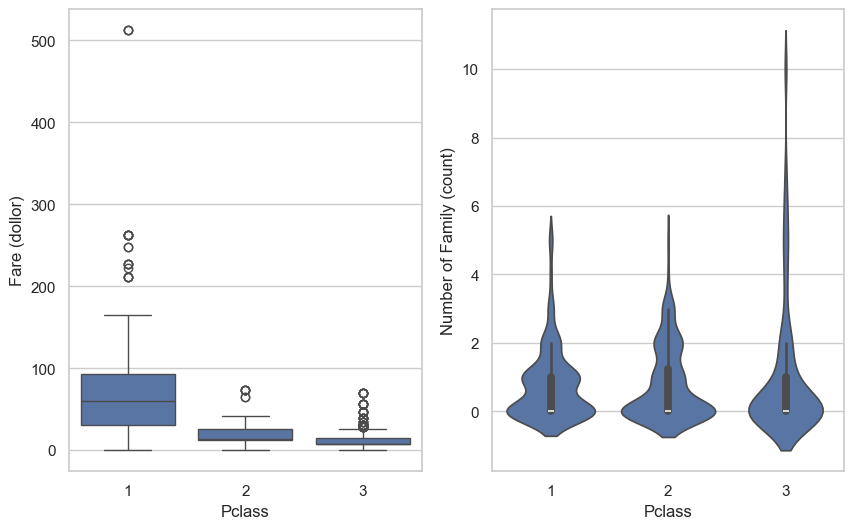

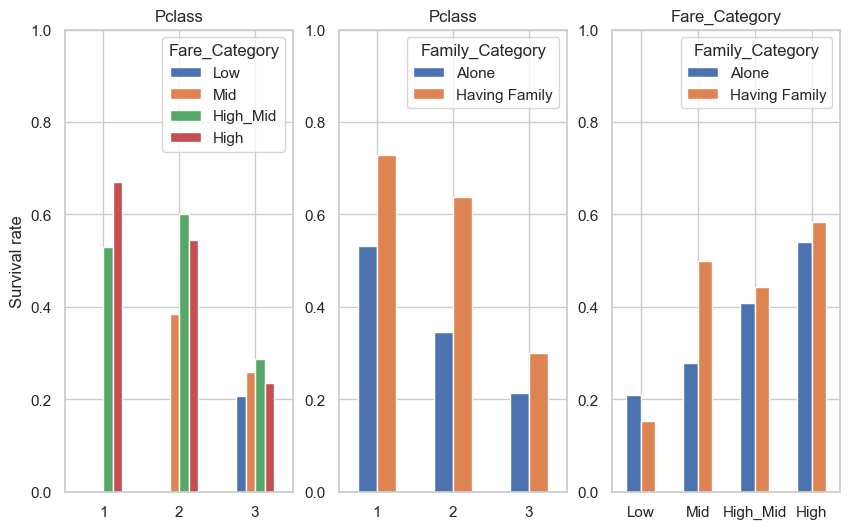

In [227]:
sns.set(style = 'whitegrid')  
fig1, axs = plt.subplots(ncols=2)
fig1.set_figheight(6)
fig1.set_figwidth(10)
sns.boxplot(data=Titanic_data, x="Pclass", y="Fare", ax=axs[0]).set_ylabel('Fare (dollor)')
sns.violinplot(data=Titanic_data, x="Pclass", y="Family_NB", ax=axs[1]).set_ylabel("Number of Family (count)") 

# interacton of Pclass X Fare_Category
fig2, axs = plt.subplots(ncols=3)
fig2.set_figheight(3)
fig2.set_figwidth(10)
Socioeco1=Titanic_data.groupby(['Pclass', 'Fare_Category'])['Survived'].mean()
Socioeco1.unstack().plot.bar(title='Pclass', xlabel='',ylabel='Survival rate', figsize=(10,6),ylim=(0,1), legend=True, rot=0, ax=axs[0])
# interacton of Pclass X Family_Category
Socioeco2=Titanic_data.groupby(['Pclass', 'Family_Category'])['Survived'].mean()
Socioeco2.unstack().plot.bar(title='Pclass', xlabel='',ylabel='', figsize=(10,6),ylim=(0,1), legend=True, rot=0, ax=axs[1])
# interacton of Fare_Category X Family_Category
Socioeco3=Titanic_data.groupby(['Fare_Category', 'Family_Category'])['Survived'].mean()
Socioeco3.unstack().plot.bar(title='Fare_Category', xlabel='',ylabel='', figsize=(10,6),ylim=(0,1), legend=True, rot=0,  ax=axs[2])

from statsmodels.multivariate.manova import MANOVA
model = ols('Survived ~ C(Pclass) + C(Fare_Category) + C(Family_Category) + C(Pclass):C(Fare_Category) + C(Family_Category):C(Fare_Category) + C(Pclass):C(Family_Category)', data=Titanic_data).fit()
sm.api.stats.anova_lm(model, typ=2)  

**7. Combined physical and socioeconomic attributes and the factor of "Embarked"**

- From the top violin plot below, there is an association between "Age" (continuous) and "Pclass", revealing the higher the Pclass where passengers belonged, the older the passengers were. The distribution of "Sex" seems to be equally distributed in each Pclass, but more male passengers in Pclass 3 compared to female passengers. Regarding the "Embarked" shown in the bottom violin plot, there is no difference in the age of passengers between C, S and Q. 

- Based on the chi-square test (Part 3), the 6 main effects (Sex, Age_Category, Pclass, Family_Category, Fare_Category, Embarked) are included in the ANOVA model, and according to their p-values, I assigned Sex and Pclass as my primary variables, and the others are my secondary variables.  The significant 2-factor interactions that were revealed in the previous analysis (Part 5 & 6) are preserved in the model, which are "Sex x Age_Category" and "Family_Category x Fare_Category". Since Sex and Pclass are my primary variable, their interaction is also included in the model, "Sex x Pclass", and additionally, "Age_Category x Pclass" was added as well. 

- The model is: 
Survived = Age + Sex + Pclass + Family_Category + Fare_Category + Embarked + Sex x Age_Category + Family_Category x Fare_Category + Sex x Pclass + Age_Category x Pclass

- From the result, "Sex", "Age_Category", "Pclass", and "Embarked" revealed significant main effects in this model, and "Sex x Pclass", "Age_Category x Pclass" and "Age_Category x Sex" revealed significant 2-factor interaction as well. 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Sex),39.868527,1.0,295.185753,1.528040e-56
C(Age_Category),8.177358,5.0,12.108998,1.465288e-09
C(Pclass),8.598514,2.0,31.831611,4.998568e-14
C(Fare_Category),0.563559,3.0,1.390859,2.442584e-01
C(Family_Category),0.003563,1.0,0.026377,8.710244e-01
C(Embarked),1.051698,2.0,3.893374,2.076421e-02
C(Family_Category):C(Fare_Category),0.224307,3.0,0.553588,6.458455e-01
C(Sex):C(Pclass),5.439461,2.0,20.136830,2.937332e-09
C(Age_Category):C(Pclass),3.042954,10.0,2.252997,1.351352e-02
C(Age_Category):C(Sex),3.143149,5.0,4.654362,3.402107e-04


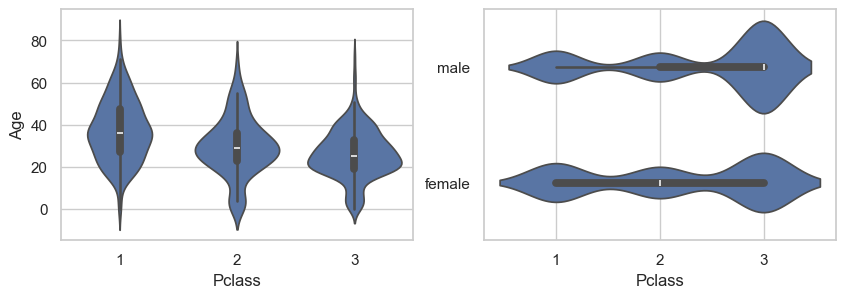

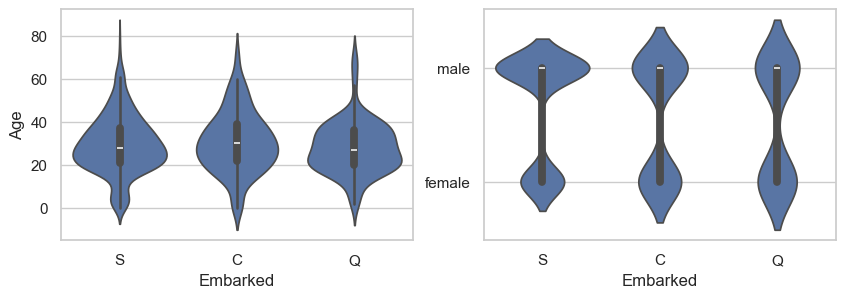

In [228]:
#Question 1-3: Main effect: Sex(primary), Age_Category, Pclass(primay), Family_Category, Fare_Category, Embarked 
#              2-factor interaction: Sex x Age_Category,  Family_Category x Fare_Category, Sex x Pclass, Age_Category x Pclass
from statsmodels.formula.api import ols
import statsmodels as sm

fig1, axs = plt.subplots(ncols=2)
fig1.set_figheight(3)
fig1.set_figwidth(10)
plt.subplot(1,2,1)
sns.violinplot(data=Titanic_data, x="Pclass", y="Age") 
plt.subplot(1,2,2)  
fig=sns.violinplot(data=Titanic_data, x="Pclass", y="Sex")
fig.set_xticks([1,2,3])
fig.set_ylabel('')


fig2, axs = plt.subplots(ncols=2)
fig2.set_figheight(3)
fig2.set_figwidth(10)
plt.subplot(1,2,1)
sns.violinplot(data=Titanic_data, x="Embarked", y="Age") 
plt.subplot(1,2,2)  
fig=sns.violinplot(data=Titanic_data, x="Embarked", y="Sex")
fig.set_ylabel('')


model = ols('Survived ~ C(Sex) + C(Age_Category) + C(Pclass) + C(Fare_Category) + C(Family_Category) +  C(Embarked) + C(Family_Category):C(Fare_Category) + C(Sex):C(Pclass)+ C(Age_Category):C(Pclass) + C(Age_Category):C(Sex)', data=Titanic_data).fit()
sm.api.stats.anova_lm(model, typ=2) 
